In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import OrthogonalMatchingPursuit
import copy
from collections import Counter

<h2>Game modeling</h2>

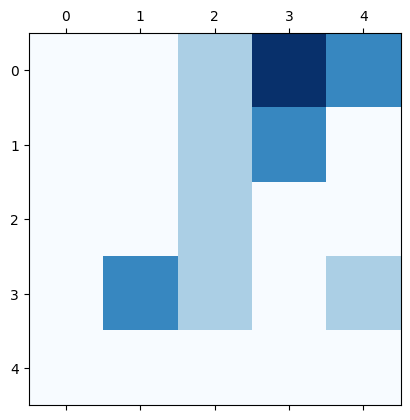

In [95]:
global possible_states
possible_states = np.matrix([[0,0,1,3,2],
                            [0,0,1,2,0],
                            [0,0,1,0,0],
                            [0,2,1,0,1],
                            [0,0,0,0,0]])
plt.matshow(possible_states, cmap=plt.cm.Blues)

In [96]:
def is_valid(a,pos,ori):
    x,y = pos
    if ori==0:
        return (x-1 >= 0)
    elif ori==1:
        return (y+1 <= 4)
    elif ori==2:
        return (x+1 <= 4)
    else:
        return (y-1 >= 0)
def take_action(a,pos,ori):
    x,y = pos
    if a==0: #turn
        position = pos
        orientation = (ori + 1) %4
    else: #go forward
        orientation = ori
        if ori==0:
            position = (x-1,y)
        elif ori==1:
            position = (x,y+1)
        elif ori==2:
            position = (x+1,y)
        else:
            position = (x,y-1)
    return position,orientation

#Cost of position as distance to the goal
def evaluate_cost(pos):

    if possible_states[pos] == 2:
        possible_states[pos] = 0
        return 200
    if possible_states[pos] == 3:
        possible_states[pos] = 0
        return 20000000
    if possible_states[pos] == 1: #holes
        return
    return 0

In [35]:
def follow_sequence_actions(sequence,position,orientation):
    cost = 0
    for action in sequence:
        if action==0 or is_valid(action,position,orientation):
            position,orientation = take_action(action,position,orientation)
            c = evaluate_cost(position)
            if c!=None:
                cost += c
            else: #hole
                return 0
        else: #invalid action
            return 0
    return cost

In [81]:
n = 12
sequence_list = np.array([np.array(list(bin(i)[3:]),dtype=np.int32) for i in range(2**n, 2**(n+1))])
len(sequence_list)

4096

In [24]:
def stringify(seq):
    string = ''
    for n in seq:
        string+=str(n)
    return string

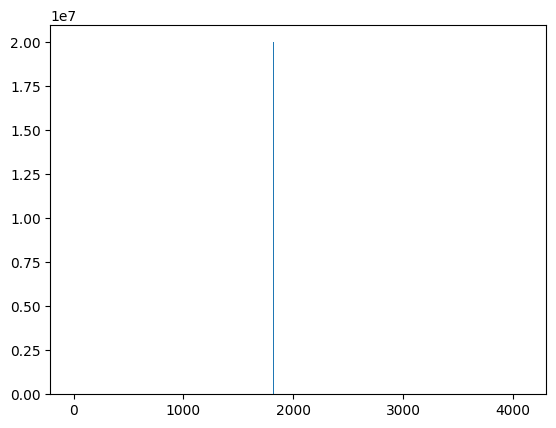

1822
[0 1 1 1 0 0 0 1 1 1 1 0]
20000200


In [97]:
position = (4,0)
orientation = 0 #0 North, 1 East, 2 south, 3 West

possible_sequence = []
possible_sequence_cost = []
for sequence in sequence_list:
    global possible_states
    possible_states = np.matrix([[0,0,1,3,2],
                                [0,0,1,2,0],
                                [0,0,1,0,0],
                                [0,2,1,0,1],
                                [0,0,0,0,0]])
    cost = follow_sequence_actions(sequence,position,orientation)
    if cost!=None:
        possible_sequence_cost.append(cost)
        possible_sequence.append(sequence)

plt.bar([i for i in np.arange(len(possible_sequence))],possible_sequence_cost,width=10)
plt.show()
ma = np.argmax(possible_sequence_cost)
print(ma)
print(possible_sequence[ma])
print(possible_sequence_cost[ma])

<h2>Compressive Sensing</h2>
<h3>Ideal compressive sensing</h3>

In [56]:
def bin_to_pattern(x):
    return [ [1-int(i), int(i)] for i in x ]

In [57]:
def create_specific_patterns(mode1,mode2,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(size-mode1-(mode2-mode1-1)-2) )
    return pats

In [58]:
def create_specific_patterns3(mode1,mode2,mode3,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            for k in range(2):
                pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(mode3-(mode2-mode1-1)-mode1-2) + bin_to_pattern(str(k)) + [[1,1]]*(size -mode1-(mode2-mode1-1)-(mode3-(mode2-mode1-1)-mode1-2)-3) )
    return pats

In [59]:
def create_specific_patterns4(mode1,mode2,mode3,mode4,size):
    pats = []
    temp_pats = create_specific_patterns3(mode1,mode2,mode3,size)
    for p in temp_pats:
        for k in range(2):
            p_prime = copy.deepcopy(p)
            p_prime[mode4] = bin_to_pattern(str(k))[0]
            pats.append(p_prime)
    return pats

In [ ]:
def dev_pattern(pat):
    f = np.array([1])
    for i in pat:
        f = np.kron(f,i)
    return f

19995316.291419383
1822
[0 1 1 1 0 0 0 1 1 1 1 0]
19995316.291419383


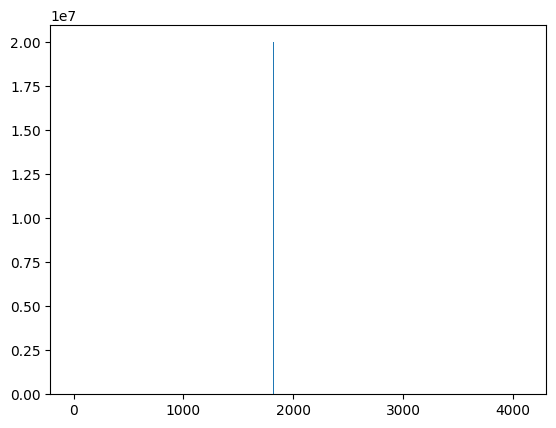

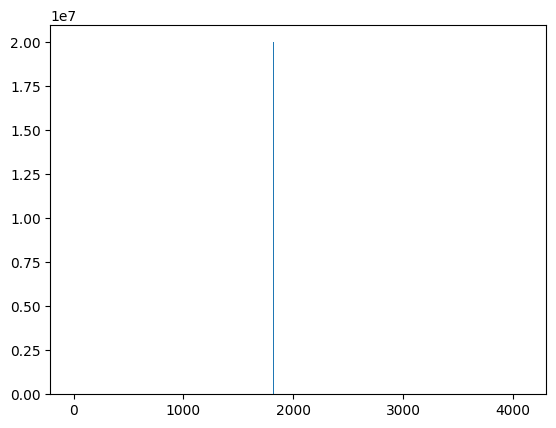

In [98]:
#Nearest neighbor measurements
all_pat = []
y = []

for bit in range(n-1):
    all_pat +=  create_specific_patterns(bit,bit+1,n)

Phi = np.array([dev_pattern(p) for p in all_pat])
y = np.array(Phi * np.matrix(possible_sequence_cost).T).T[0]

omp = OrthogonalMatchingPursuit(n_nonzero_coefs=20)
omp.fit(Phi, y)
coefficients = [ i if i>0 else 0 for i in omp.coef_]

print(coefficients[1822])
ma = np.argmax(coefficients)
print(ma)
print(possible_sequence[ma])
print(coefficients[ma])

plt.bar([i for i in np.arange(len(possible_sequence))],possible_sequence_cost,width=10)
plt.show()
plt.bar([i for i in np.arange(len(coefficients))],coefficients,width=10)
plt.show()
# y_ideal = y

20000499.80601399
1822
[0 1 1 1 0 0 0 1 1 1 1 0]
20000499.80601399


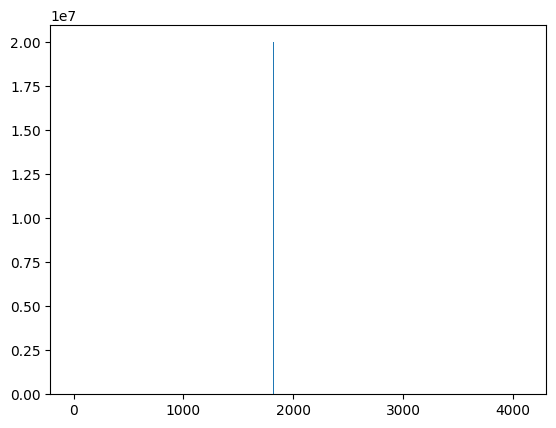

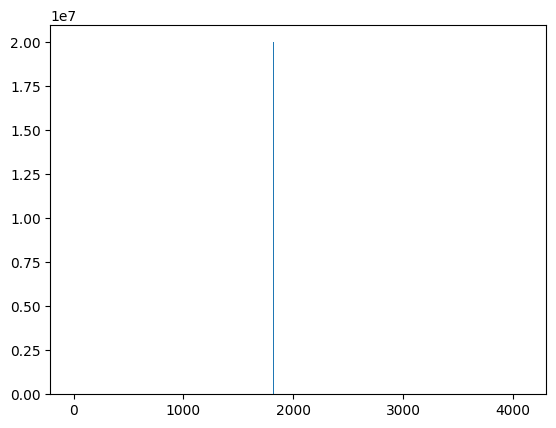

In [99]:
#Quadruplets measurements
all_pat = []
y = []

all_pat = []
for i in range(n):
    for j in range(i+1,n):
        # all_pat += create_specific_patterns(i,j,n)
        for k in range(j+1,n):
            # all_pat += create_specific_patterns3(i,j,k,n)
            for l in range(k+1,n):
                all_pat += create_specific_patterns4(i,j,k,l,n)

# print(len(all_pat))

Phi = np.array([dev_pattern(p) for p in all_pat])
y = np.array(Phi * np.matrix(possible_sequence_cost).T).T[0]

omp = OrthogonalMatchingPursuit(n_nonzero_coefs=30)
omp.fit(Phi, y)
coefficients = [ i if i>0 else 0 for i in omp.coef_]

print(coefficients[1822])
ma = np.argmax(coefficients)
print(ma)
print(possible_sequence[ma])
print(coefficients[ma])

plt.bar([i for i in np.arange(len(possible_sequence))],possible_sequence_cost,width=10)
plt.show()
plt.bar([i for i in np.arange(len(coefficients))],coefficients,width=10)
plt.show()

20000280.114827797
1822
[0 1 1 1 0 0 0 1 1 1 1 0]
20000280.114827797


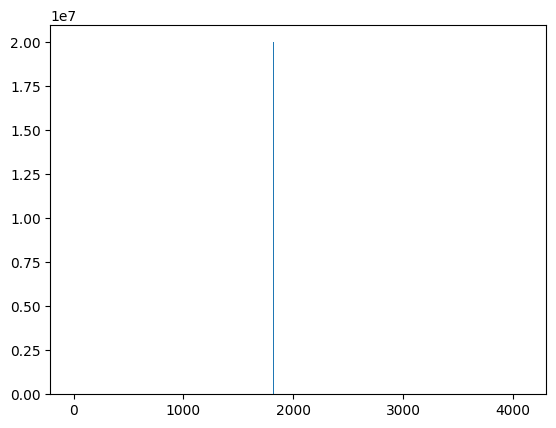

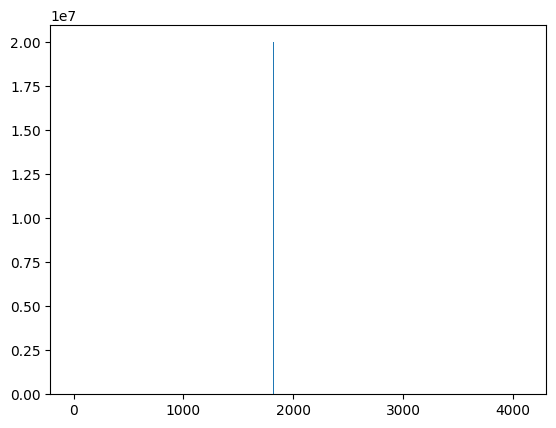

In [100]:
#Random measurements
cheat_Phi = np.random.rand(200,2**n)
cheat_y = np.array(cheat_Phi * np.matrix(possible_sequence_cost).T).T[0]

omp = OrthogonalMatchingPursuit(n_nonzero_coefs=20)
omp.fit(cheat_Phi, cheat_y)
coefficients = [ i if i>0 else 0 for i in omp.coef_]

print(coefficients[1822])
ma = np.argmax(coefficients)
print(ma)
print(possible_sequence[ma])
print(coefficients[ma])

plt.bar([i for i in np.arange(len(possible_sequence))],possible_sequence_cost,width=10)
plt.show()
plt.bar([i for i in np.arange(len(coefficients))],coefficients,width=10)
plt.show()

<h3>Estimated measurement monte carlo</h3>

In [122]:
#Sample from possible sequences (be careful not to take the solution already)
seq_sample = []
seq_sample_cost = []
for _ in range(1000):
    i = np.random.randint(0,len(possible_sequence))
    seq_sample.append(possible_sequence[i])
    seq_sample_cost.append(possible_sequence_cost[i])
    if i==1822:
        print("inside")

In [103]:
def estimate_measurement(bit1,bit2,v1,v2):
    costs = []
    for seq,cost in zip(seq_sample,seq_sample_cost):
        if seq[bit1]==v1 and seq[bit2]==v2:
            costs.append(cost)
    if costs == []:
        return
    else:
        return np.sum(costs)

In [123]:
all_pat = []
y = []

for bit in range(n-1):
    all_pat +=  create_specific_patterns(bit,bit+1,n)
    for v1 in range(2):
        for v2 in range(2):
            # print(v1,v2)
            res = estimate_measurement(bit,bit+1,v1,v2)
            if res!=None:
                y.append(res)

Phi = np.array([dev_pattern(p) for p in all_pat])

y = np.array(y)*2
y

array([2400, 6000, 7200, 2800, 4800, 4800, 6400, 2400, 8400, 2800, 5600,
       1600, 8000, 6000, 4000,  400, 6800, 5200, 5600,  800, 6000, 6400,
       4000, 2000, 4800, 5200, 5200, 3200, 6400, 3600, 5600, 2800, 4800,
       7200, 5600,  800, 6000, 4400, 5200, 2800, 4400, 6800, 4800, 2400])

In [114]:
def estimate_measurement_all_pairs(bit1,bit2):
    costs = []
    all_cost = []
    for v1 in range(2):
        for v2 in range(2):
            for seq,cost in zip(seq_sample,seq_sample_cost):
                if seq[bit1]==v1 and seq[bit2]==v2:
                    costs.append(cost)
            if costs == []:
                all_cost.append(0)
            else:
                all_cost.append(np.sum(costs))
    return all_cost

In [115]:
all_pat = []
y = []

all_pat = []
for i in range(n):
    for j in range(i+1,n):
        all_pat += create_specific_patterns(i,j,n)
        y += estimate_measurement_all_pairs(i,j)

# print(len(all_pat))

Phi = np.array([dev_pattern(p) for p in all_pat])
y = np.array(y)
y

array([     800, 20002600, 20005800, 20007800,     1600, 20002600,
       20005400, 20007800,     2000, 20002600, 20006000, 20007800,
       20001800, 20002600, 20006200, 20007800, 20001400, 20002600,
       20005800, 20007800, 20001000, 20002600, 20005200, 20007800,
           1600, 20002600, 20005400, 20007800,     2200, 20002600,
       20005800, 20007800,     1200, 20002600, 20005800, 20007800,
           1600, 20002600, 20005200, 20007800, 20001400, 20002600,
       20006000, 20007800,     2000,     4000,     6400, 20007800,
           3400,     4000,     6000, 20007800,     2400,     4000,
       20007000, 20007800,     2800,     4000, 20005800, 20007800,
           1600,     4000, 20006000, 20007800,     2400,     4000,
           6000, 20007800,     2600,     4000,     6800, 20007800,
           2600,     4000,     5800, 20007800,     2200,     4000,
           6000, 20007800,     2800,     4000, 20006000, 20007800,
           2800,     4400,     7000, 20007800,     3400,     4

In [118]:
def estimate_measurement_random_pat(pat):
    cost = 0
    for p,c in zip(pat,seq_sample_cost):
        cost += p*c
    return cost

In [119]:
Phi = cheat_Phi
y = []

for phi in Phi:
    y.append(estimate_measurement_random_pat(phi))
y = np.array(y)
y

array([16642764.30784786, 19226101.96897986,  4864180.23529665,
        7972683.23044806,  3970134.20960436, 13987928.26167452,
         783810.60584985, 15422451.68051311,  5425735.77058875,
        5931271.34454918, 17197177.33210816, 13845681.92047455,
        9248845.63112075,  5779675.9590369 , 17979597.72268815,
        8222807.71408872,  8729136.16113208,  4236624.41814212,
       15920975.31716641,  3574178.41842544, 18596371.36891685,
        3882294.754584  , 11047245.65620438,  7037123.14672624,
       16196698.95694651,  2047984.08180067,  8433916.19794384,
        7269692.88579611,  4964783.26608775,  7885053.86412611,
       16222858.5895096 ,  3228064.28780258,  4776286.787487  ,
       17387770.06006022,  6450940.62572371, 13088040.51486561,
       15278479.34885602, 15588010.13624937,  6650222.6257217 ,
        4200616.02060831, 17600230.20812931,  3395750.17881062,
        9760127.3828442 , 14489879.46277056,  1854307.44929927,
         908920.58974883,  9932189.10449

c:\Users\Baptiste\Documents\PhD\.venv\Lib\site-packages\sklearn\linear_model\_omp.py:445: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(


0
2561
[1 0 1 0 0 0 0 0 0 0 0 1]
1599.9999999999998


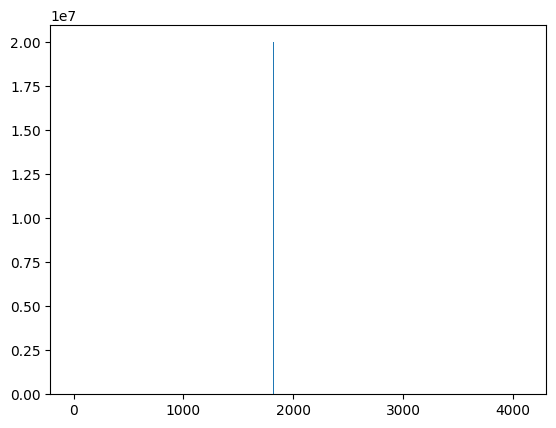

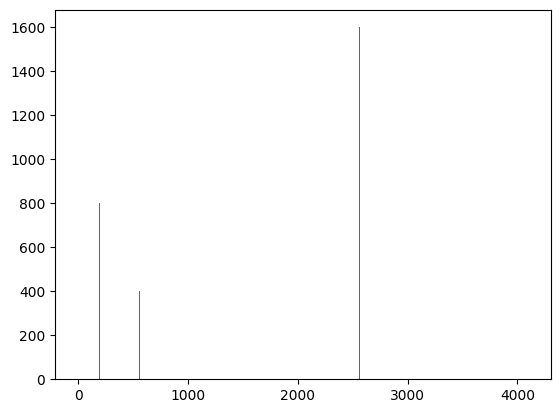

In [124]:
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=20)
omp.fit(Phi, y)
coefficients = [ i if i>0 else 0 for i in omp.coef_]

print(coefficients[1822])
ma = np.argmax(coefficients)
print(ma)
print(possible_sequence[ma])
print(coefficients[ma])

plt.bar([i for i in np.arange(len(possible_sequence))],possible_sequence_cost,width=10)
plt.show()
plt.bar([i for i in np.arange(len(coefficients))],coefficients,width=10)
plt.show()